# Naive Bayes classifier for Fake News recognition

##  &nbsp;&nbsp;&nbsp; -- &nbsp;&nbsp; Peri Andrea, Orlando Filippo, Mojsovska Marija

### Packages

In [1]:
library("stringr")   # we used some function from this library in the data preprocessing section
library("ggplot2")
library("dplyr")


Caricamento pacchetto: 'dplyr'


I seguenti oggetti sono mascherati da 'package:stats':

    filter, lag


I seguenti oggetti sono mascherati da 'package:base':

    intersect, setdiff, setequal, union




## Load and preprocessing data

In [2]:
raw_training <- read.csv("train_corrected.csv")  # raw_training is a dataframe containing with columns: Labels - Text - Text_Tag
raw_training <- filter(raw_training, Labels==1 | Labels==5)

training_set <- raw_training$Text    # we retain only Text and Labels columns as vectors
labels <- raw_training$Labels

l_set <- length(training_set)
cat(paste("Total number of documents: ",l_set))

Total number of documents:  3667

In [3]:
set.seed(253)     # set the seed in order to exploit the algorithm on the same training data at every run
permutation <- sample(1:l_set, replace=FALSE)    # introduce a random permutation to shuffle the dataset

training_set <- training_set[permutation]
labels <- labels[permutation]

In the next cell, different operations are applied at the raw set:
* First, all punctuation element are replaced with a blanck space &nbsp;&nbsp;&nbsp;&nbsp; (inner gsub() function)
* Then, all the newline special characters (\n) are deleted &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (outer gsub() function)
* All characters are represented in lowercase &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (tolower() function)
* The spaces at the end of every document are deleted &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (str_trim() function)
* Finally, every document is splitted in single words &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (str_split() function)

In [4]:
training_set = str_split(str_trim(tolower(gsub("\n","",gsub('[[:punct:] ]+',' ',training_set))), "right"), " ")

In [5]:
# create training and test sets, with the first p% of data joined in the training set
test_set <- training_set[round(0.85*l_set):l_set];     labels_test <- labels[round(0.85*l_set):l_set]
training_set <- training_set[1:round(0.85*l_set)-1];   labels <- labels[1:round(0.85*l_set)-1]

In [6]:
training_set[1:5]

[[1]]
 [1] "we"        "have"      "the"       "highest"   "corporate" "tax"      
 [7] "rate"      "in"        "the"       "world"     "its"       "35"       
[13] "percent"  

[[2]]
 [1] "says"    "texas"   "gained"  "21"      "000"     "doctors" "due"    
 [8] "to"      "tort"    "reform" 

[[3]]
 [1] "he"             "won"            "t"              "even"          
 [5] "support"        "his"            "colleague"      "s"             
 [9] "motion"         "to"             "censure"        "the"           
[13] "bush"           "administration" "for"            "systemic"      
[17] "repeated"       "illegal"        "wiretaps"      

[[4]]
 [1] "the"        "radiation"  "coming"     "from"       "the"       
 [6] "new"        "tsa"        "body"       "scanners"   "is"        
[11] "equivalent" "to"         "about"      "three"      "minutes"   
[16] "worth"      "of"         "air"        "travel"     "by"        
[21] "anybody"    "say"        "at"         "30"         "000"       
[26] "feet"      

[[5]]
 [1] "after"         "shedding"      "jobs"          "for"          
 [5] "more"          "than"          "10"            "years"        
 [9] "our"           "manufacturers" "have"          "added"        
[13] "about"         "500"           "000"           "jobs"         
[17] "over"          "the"           "past"          "three"

## Extract vocabulary

Create a vector "voc" which contains all the words in the training set

In [7]:
start_time <- Sys.time()

voc <- character()

for (i in training_set){
    for(j in i){
        if (!(j %in% voc))
            voc <- c(voc,j)
    }
}

end_time <- Sys.time()
end_time - start_time

Time difference of 1.194867 secs

In [8]:
cat(paste("Total number of words in the training set: ",length(voc)))

Total number of words in the training set:  6785

## Count number of documents in each class

In [9]:
# the variables doc_i in this cell will contain the documents in the training set with label i
doc1 <- training_set[labels == 1]  
doc5 <- training_set[labels == 5] 

In [10]:
# counting the number of documents for each class
N1 <- length(doc1);  N5 <- length(doc5);
N_doc <- c(N1,N5)
N <- sum(N_doc)

cat(paste("N1 = ",N1,"\nN5 = ",N5,"\nNumber of documents = ",N))

N1 =  1688 
N5 =  1428 
Number of documents =  3116

## Compute count_table

The table will contain the number of appearances for each word in all the documents in each class. 

This is needed to apply the classifier (the count of the words will be the likelihood)

In [13]:
# function which count the number of times a word appears in a specified subset of training documents
count_w_in_c <- function(word, selected_doc){ 
    count <- 0
    for (i in seq_along(selected_doc)){            # run through the list of documents passed to the function
        for (j in seq_along(selected_doc[[i]])){   # run through each word of the selected document
            if (selected_doc[[i]][j] == word)
                count <- count + 1                 # increase count if there is a match with the word passed to the function
        }
    }
    return(count)
}

In [14]:
start_time <- Sys.time()

count_table <- matrix(nrow=length(voc), ncol=3) 

# iterate over all the words in vocabulary
# for each word, compute the number of times it appears in the documents of each class
for (i in seq_along(voc))
    count_table[i,] <- c(voc[i], count_w_in_c(voc[i],doc1), count_w_in_c(voc[i],doc5))

# convert to DataFrame and assign column names
count_table <- as.data.frame(count_table)
colnames(count_table) <- c("word","count1","count5")

# convert the count columns type to double
count_table["count1"] <- as.numeric(unlist(count_table["count1"]))
count_table["count5"] <- as.numeric(unlist(count_table["count5"]))

end_time <- Sys.time()
end_time - start_time

Time difference of 1.942319 mins

In [15]:
head(count_table)

,word,count1,count5
,<chr>,<dbl>,<dbl>
1,we,145,159
2,have,171,214
3,the,1487,1459
4,highest,9,26
5,corporate,4,8
6,tax,111,89


In [16]:
# save and reload count_table in order to speed up the testing phase of the algorithm
write.table(count_table, file="count_table_bin.csv", sep=',', quote=FALSE)

In [ ]:
### Load count_table

In [11]:
count_table <- read.table("count_table_bin.csv", sep=',', header=TRUE)

In [12]:
head(count_table)

,word,count1,count5
,<chr>,<int>,<int>
1,we,145,159
2,have,171,214
3,the,1487,1459
4,highest,9,26
5,corporate,4,8
6,tax,111,89


## Feature selection

### Compute count_doc_table

This table will contain the number of documents for each class which contain a specific word

This information is needed to use Mutual Information and $\chi^2$ as feature selection strategies

In [19]:
# function which count the number of documents in a specified subset of the training set which contain a word
count_wd_in_c <- function(word, selected_doc){ 
    count <- 0
    for (i in seq_along(selected_doc)){
        if (word %in% selected_doc[[i]])
            count <- count + 1
    }
    return(count)
}

In [20]:
start_time <- Sys.time()

count_doc_table <- matrix(data=NA, nrow=nrow(count_table), ncol=5)

# iterate over all the words in vocabulary
# for each word, compute the number of documents for each class which contain it, and the number of documents not in the class whch contain the word
# the last column contain the total number of documents which contain the word
for (i in seq_along(voc)){
    count1 <- count_wd_in_c(voc[i], doc1)
    count5 <- count_wd_in_c(voc[i], doc5)
    count_sum <- sum(c(count1,count5))
    
    count_doc_table[i,1] <- count1;  count_doc_table[i,2] <- count_sum - count1
    count_doc_table[i,3] <- count5;  count_doc_table[i,4] <- count_sum - count5
    count_doc_table[i,5] <- count_sum;
}

# convert to DataFrame and assign column names
count_doc_table <- as.data.frame(cbind(count_table[,1],count_doc_table))
colnames(count_doc_table) <- c("word","l1_N11","l1_N10","l5_N11","l5_N10","count_sum")

# convert the count columns type to double
count_doc_table["l1_N11"] <- as.numeric(unlist(count_doc_table["l1_N11"]));  count_doc_table["l1_N10"] <- as.numeric(unlist(count_doc_table["l1_N10"]))
count_doc_table["l5_N11"] <- as.numeric(unlist(count_doc_table["l5_N11"]));  count_doc_table["l5_N10"] <- as.numeric(unlist(count_doc_table["l5_N10"]))
count_doc_table["count_sum"] <- as.numeric(unlist(count_doc_table["count_sum"]))

end_time <- Sys.time()
end_time - start_time

Time difference of 24.81326 secs

In [21]:
head(count_doc_table)

,word,l1_N11,l1_N10,l5_N11,l5_N10,count_sum
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,we,120,130,130,120,250
2,have,158,189,189,158,347
3,the,972,893,893,972,1865
4,highest,9,23,23,9,32
5,corporate,4,8,8,4,12
6,tax,102,75,75,102,177


In [22]:
# save and reload count_doc_table in order to speed up the testing phase of the algorithm
write.table(count_doc_table, file="count_doc_table.csv", sep=',', quote=FALSE)

#### Load count_doc_table

In [13]:
count_doc_table <- read.table("count_doc_table.csv", sep=',', header=TRUE)

In [14]:
head(count_doc_table)

,word,l1_N11,l1_N10,l5_N11,l5_N10,count_sum
,<chr>,<int>,<int>,<int>,<int>,<int>
1,we,120,130,130,120,250
2,have,158,189,189,158,347
3,the,972,893,893,972,1865
4,highest,9,23,23,9,32
5,corporate,4,8,8,4,12
6,tax,102,75,75,102,177


### Compute Mutual Information

In [15]:
start_time <- Sys.time()

MI_table <- numeric(length(voc))

# for every word in the vocabulary, compute the Mutual Information with respect to each class
for (i in seq_along(voc))
        MI_table[i] <- 1/N*(count_doc_table[i,2]*log2((N*count_doc_table[i,2]+1e-5)/(count_doc_table[i,6]*N_doc[1])) +  (N_doc[1]-count_doc_table[i,2])*log2((N*(N_doc[1]-count_doc_table[i,2])+1e-5)/((N-count_doc_table[i,6])*N_doc[1])) + count_doc_table[i,3]*log2((N*count_doc_table[i,3]+1e-5)/(count_doc_table[i,6]*(N-N_doc[1])))  +  (N-N_doc[1]-count_doc_table[i,3])*log2((N*(N-N_doc[1]-count_doc_table[i,3])+1e-5)/((N-count_doc_table[i,6])*(N-N_doc[1]))))

# convert to DataFrame and assign column names
MI_table <- as.data.frame(cbind(voc,MI_table))
colnames(MI_table) <- c("word","Rank")

# convert the ranking columns type to double
MI_table["Rank"] <- as.numeric(unlist(MI_table["Rank"]))

end_time <- Sys.time()
end_time - start_time

Time difference of 1.129703 secs

In [16]:
head(MI_table)

,word,Rank
,<chr>,<dbl>
1,we,0.0009617094
2,have,0.0027066193
3,the,0.0018306042
4,highest,0.0020819097
5,corporate,0.0004908278
6,tax,0.0002098230


### Compute $\chi^2$

In [17]:
start_time <- Sys.time()

chi_table <- numeric(length(voc))

# for every word in the vocabulary, compute the Chi Square with respect for each class
for (i in seq_along(voc))
        chi_table[i] <- N * (count_doc_table[i,2]*(N-N_doc[1]-count_doc_table[i,3]) - count_doc_table[i,3]*(N_doc[1]-count_doc_table[i,2]))^2 / (as.double(N_doc[1]) * count_doc_table[i,6] * (N-N_doc[1]) * (N-count_doc_table[i,6]))

# convert to DataFrame and assign column names
chi_table <- as.data.frame(cbind(voc,chi_table))
colnames(chi_table) <- c("word","Rank")

# convert the ranking columns type to double
chi_table["Rank"] <- as.numeric(unlist(chi_table["Rank"]))

end_time <- Sys.time()
end_time - start_time

Time difference of 0.687964 secs

In [18]:
head(chi_table)

,word,Rank
,<chr>,<dbl>
1,we,4.1707055
2,have,11.7384976
3,the,7.8947156
4,highest,8.8357463
5,corporate,2.1071319
6,tax,0.9023758


### Extract a vocabulary for each class

In [276]:
# select the strategy to be used to exploit feature selection
method_to_use <- "MI"
method_to_use <- "chi"

# select the number of features we want to retain
N_features_retained <- 20

if (method_to_use == "MI"){
        MI_table_sorted <- MI_table[order(-MI_table[,2]),1]        # sort in descending order the ranking dataframe
        voc_class <- MI_table_sorted[1:N_features_retained]        # keeping only the first N_features_retained rows
} else{
        chi_table_sorted <- chi_table[order(-chi_table[,2]),1]        # sort in descending order the ranking dataframe
        voc_class <- chi_table_sorted[1:N_features_retained]    # keeping only the first N_features_retained rows
}

We obtain a different vocabulary for each class

In [277]:
voc_class[1:5]

[1] "than"  "of"    "more"  "since" "in"

## Test the algorithm

"count_in_vocc" matrix is a restriction of "count_doc_table" only to the words retained as features.

In [278]:
count_in_vocc <- matrix(data=NA, nrow=length(voc_class), ncol=2)

for (i in 1:nrow(count_in_vocc)){
    for (j in 1:ncol(count_in_vocc)){
        count_in_vocc[i,j] <- count_table[count_table["word"]==voc_class[i],j+1]
    }
}

sum_in_vocc <- apply(count_in_vocc, 2, sum)  # count the total number of words (in the restricted vocabulary) for each class

### Define the classifier

In [279]:
classifier <- function(test_set){
    # this matrix will contain the log-posterior for each word to be found in a specific document class
    posteriors <- matrix(data=NA, nrow=length(test_set), ncol=2)
    
    for (i in seq_along(test_set)){        # iterate over the test documents
        for (j in 1:2){                    # iterate over each class
            logl <- 0
            for (k in test_set[[i]]){      # iterate over each word of the selected document
                if (k %in% voc_class)  # if the selected word is in the new vocabulary, use it to compute the log-likelihood
                    logl <- logl + log((count_table[count_table["word"]==k,j+1]+1)/(sum_in_vocc[j]+N_features_retained))
            }
            posteriors[i,j] <- log(N_doc[j]/N) + logl   # add the logarithm of the prior
        }
    }
    return(posteriors)
}

### Apply the classifier to the test set

In [280]:
posteriors <- classifier(test_set)
predictions <- apply(posteriors, 1, which.max)    # set the column index in the matrix where the log-posterior is maximum to be the class identified by the algorithm
predictions <- replace(predictions, predictions==2, 5)

### Compute the accuracy reached by the algorithm

In [281]:
count_errors <- 0
for (i in seq_along(labels_test)){
    if (predictions[i] != labels_test[i])
        count_errors <- count_errors + 1
}
count_errors <- count_errors / length(labels_test)
accuracy <- 1 - count_errors
accuracy

[1] 0.6098004

In [282]:
posteriors <- classifier(training_set)
predictions <- apply(posteriors, 1, which.max)
predictions <- replace(predictions, predictions==2, 5)

count_errors <- 0
for (i in seq_along(labels)){
    if (predictions[i] != labels[i])
        count_errors <- count_errors + 1
}
count_errors <- count_errors / length(labels)
accuracy <- 1 - count_errors
accuracy

[1] 0.6193838

## Plots:  accuracy vs number of features, strategy for feature selection

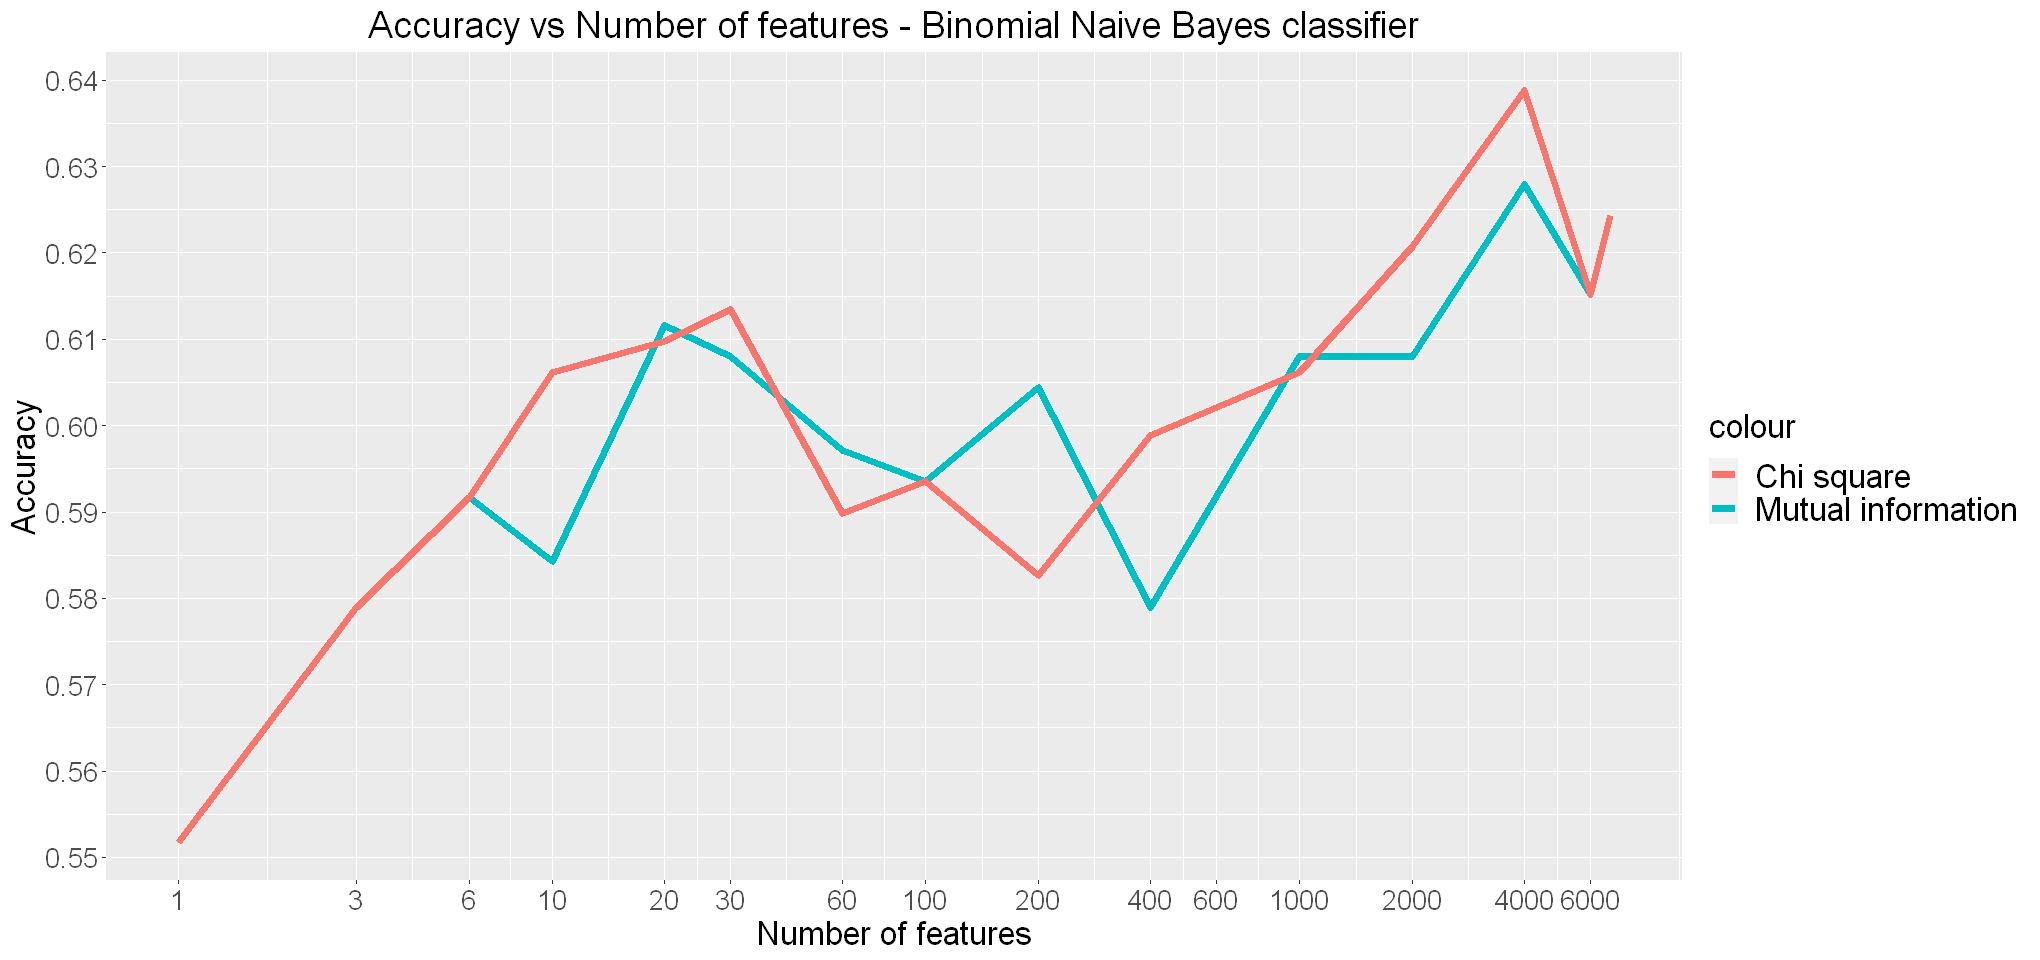

In [2]:
test_accuracy <- data.frame(n_features = c(1,3,6,10,20,30,60,100,200,400,1000,2000,4000,6000,6785), MI_test <- c(0.5517,0.5789,0.5917,0.5843,0.6116,0.6080,0.5971,0.5935,0.6044,0.5789,0.6080,0.6080,0.6279,0.6152,0.6243), chi_test<- c(0.5517,0.5789,0.5917,0.6062,0.6098,0.6134,0.5898,0.5935,0.5826,0.5989,0.6062,0.6207,0.6388,0.6152,0.6243))

options(repr.plot.width=17, repr.plot.height=8)
ggplot(test_accuracy, aes(x=n_features)) +
    geom_line(aes(y=MI_test, color="Mutual information"), size=2) +
    geom_line(aes(y=chi_test, color="Chi square"), , size=2) +
    ggtitle("Accuracy vs Number of features - Binomial Naive Bayes classifier") +
    scale_x_continuous(name="Number of features", trans='log10', breaks = c(1,3,6,10,20,30,60,100,200,400,600,1000,2000,4000,6000)) +
    scale_y_continuous(name="Accuracy", breaks = c(0.55,0.56,0.57,0.58,0.59,0.6,0.61,0.62,0.63,0.64)) +
    theme(axis.text = element_text(size = 16), axis.title = element_text(size = 20), legend.text = element_text(size = 20), legend.title = element_text(size = 20), plot.title = element_text(size=22, hjust = 0.5))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99caf2c3-6727-4825-b13d-5c8c77cf4cb9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>